<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/timeseries_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.1 MB/s eta 0:00:00


In [164]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib.patches import ConnectionPatch
import scipy.spatial.distance as dist
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from sklearn.decomposition import PCA
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
plt.rcParams['figure.figsize'] = [25, 8]

In [28]:
df = pd.read_csv('cust_prod_loc_week_order_agg.csv')
df['PERIOD_WEEK'].drop_duplicates()

,PERIOD_WEEK
0,202401.0
91,202402.0
179,202403.0
262,202404.0
372,202405.0
501,202406.0
624,202407.0
719,202408.0
837,202409.0
957,202410.0


In [32]:
df[df['PERIOD_WEEK'].isna()]

,PERIOD_WEEK,PROD_ID,DELIVERED_DC_NAME,HIER_SAP1_LVL_1_NAME,TOTAL_ORDERED_QUANTITY
7187,NaN,DCN680D1,166 Hagerstown DC,HOME DEPOT CORPORATE,135
7188,NaN,DCN920B,166 Hagerstown DC,HOME DEPOT CORPORATE,53
7189,NaN,DCN623D1,166 Hagerstown DC,HOME DEPOT CORPORATE,13
7190,NaN,DCN650D1,166 Hagerstown DC,HOME DEPOT CORPORATE,11
7191,NaN,DCN660D1,166 Hagerstown DC,HOME DEPOT CORPORATE,8
7192,NaN,DCN680B,166 Hagerstown DC,HOME DEPOT CORPORATE,7
7193,NaN,DCN45RND1,166 Hagerstown DC,HOME DEPOT CORPORATE,3
7194,NaN,DCN680D1,166 Hagerstown DC,LBM ADVANTAGE,2


In [36]:
df.shape

(7195, 5)

In [37]:
df = df.dropna()
df.shape

(7187, 5)

In [40]:
df['PERIOD_WEEK'] = df['PERIOD_WEEK'].astype(str)
df['PERIOD_WEEK'] = df['PERIOD_WEEK'].apply(lambda x : x[:6])
df = df[df['PERIOD_WEEK'] <= '202452']
df.shape

(7064, 5)

In [41]:
df['PERIOD_WEEK'].drop_duplicates()

,PERIOD_WEEK
0,202401
91,202402
179,202403
262,202404
372,202405
501,202406
624,202407
719,202408
837,202409
957,202410


In [42]:
df.head()

,PERIOD_WEEK,PROD_ID,DELIVERED_DC_NAME,HIER_SAP1_LVL_1_NAME,TOTAL_ORDERED_QUANTITY
0,202401,DCN680D1,"155 FT. MILL BLACK & DECKER CORP,",HOME DEPOT CORPORATE,331
1,202401,DCN623D1,"155 FT. MILL BLACK & DECKER CORP,",HOME DEPOT CORPORATE,232
2,202401,DCN660D1,"155 FT. MILL BLACK & DECKER CORP,",HOME DEPOT CORPORATE,123
3,202401,DCN680B,"155 FT. MILL BLACK & DECKER CORP,",HOME DEPOT CORPORATE,116
4,202401,DCN650D1,"155 FT. MILL BLACK & DECKER CORP,",HOME DEPOT CORPORATE,94


In [43]:
df_dc_agg = df.groupby(['PERIOD_WEEK', 'PROD_ID', 'DELIVERED_DC_NAME']).agg({'TOTAL_ORDERED_QUANTITY': 'sum'}).reset_index()
df_dc_agg

,PERIOD_WEEK,PROD_ID,DELIVERED_DC_NAME,TOTAL_ORDERED_QUANTITY
0,202401,CMCB204-2,162 Northlake DC,8
1,202401,CMCB204-2,"164 Fontana DC Black & Decker,Inc.",8
2,202401,CMCN618B,162 Northlake DC,18
3,202401,DCN45RND1,"155 FT. MILL BLACK & DECKER CORP,",54
4,202401,DCN45RND1,162 Northlake DC,48
...,...,...,...,...
1789,202452,DCN920B,"164 Fontana DC Black & Decker,Inc.",180
1790,202452,DCN920B,166 Hagerstown DC,44
1791,202452,DWFP1KIT,162 Northlake DC,8
1792,202452,DWFP1KIT,"164 Fontana DC Black & Decker,Inc.",904


In [47]:
unique_products = df_dc_agg['PROD_ID'].unique()
unique_dcs = df_dc_agg['DELIVERED_DC_NAME'].unique()
unique_weeks = df_dc_agg['PERIOD_WEEK'].unique()
unique_products, unique_dcs, unique_weeks

(array(['CMCB204-2', 'CMCN618B', 'DCN45RND1', 'DCN623D1', 'DCN650D1',
        'DCN660D1', 'DCN680B', 'DCN680D1', 'DCN920B', 'DWFP1KIT'],
       dtype=object),
 array(['162 Northlake DC', '164 Fontana DC Black & Decker,Inc.',
        '155 FT. MILL BLACK & DECKER CORP,', '166 Hagerstown DC'],
       dtype=object),
 array(['202401', '202402', '202403', '202404', '202405', '202406',
        '202407', '202408', '202409', '202410', '202411', '202412',
        '202413', '202414', '202415', '202416', '202417', '202418',
        '202419', '202420', '202421', '202422', '202423', '202424',
        '202425', '202426', '202427', '202428', '202429', '202430',
        '202431', '202432', '202433', '202434', '202435', '202436',
        '202437', '202438', '202439', '202440', '202441', '202442',
        '202443', '202444', '202445', '202446', '202447', '202448',
        '202449', '202450', '202451', '202452'], dtype=object))

In [52]:
df_driver = pd.DataFrame(list(itertools.product(unique_weeks, unique_dcs, unique_products)), columns = ['PERIOD_WEEK', 'DELIVERED_DC_NAME', 'PROD_ID'])
df_driver

,PERIOD_WEEK,DELIVERED_DC_NAME,PROD_ID
0,202401,162 Northlake DC,CMCB204-2
1,202401,162 Northlake DC,CMCN618B
2,202401,162 Northlake DC,DCN45RND1
3,202401,162 Northlake DC,DCN623D1
4,202401,162 Northlake DC,DCN650D1
...,...,...,...
2075,202452,166 Hagerstown DC,DCN660D1
2076,202452,166 Hagerstown DC,DCN680B
2077,202452,166 Hagerstown DC,DCN680D1
2078,202452,166 Hagerstown DC,DCN920B


In [54]:
df_dc_agg_v1 = pd.merge(df_driver, df_dc_agg, on = ['PERIOD_WEEK', 'DELIVERED_DC_NAME', 'PROD_ID'], how = 'left')

In [56]:
df_dc_agg_v1.groupby(['PROD_ID', 'DELIVERED_DC_NAME'])['PERIOD_WEEK'].count()

PROD_ID    DELIVERED_DC_NAME                 
CMCB204-2  155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
CMCN618B   155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DCN45RND1  155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DCN623D1   155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DCN650D1   155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DCN660D1   155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DCN680B    155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DCN680D1   155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DCN920B    155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
DWFP1KIT   155 FT. MILL BLACK & DECKER CORP,     52
           162 Northlake DC                      52
           164 Fontana DC Black & Decker,Inc.    52
           166 Hagerstown DC                     52
Name: PERIOD_WEEK, dtype: int64

In [61]:
df_dc_agg_v1['DC_PROD_ID'] = df_dc_agg_v1['DELIVERED_DC_NAME'] + ' ~ ' + df_dc_agg_v1['PROD_ID']

In [63]:
df_dc_agg_v2 = df_dc_agg_v1.pivot_table(index=['DC_PROD_ID'], columns='PERIOD_WEEK', values='TOTAL_ORDERED_QUANTITY').reset_index().fillna(0)
df_dc_agg_v2

PERIOD_WEEK,DC_PROD_ID,202401,202402,202403,202404,202405,202406,202407,202408,202409,...,202443,202444,202445,202446,202447,202448,202449,202450,202451,202452
0,"155 FT. MILL BLACK & DECKER CORP, ~ CMCB204-2",0.0,0.0,676.0,2424.0,1362.0,1087.0,246.0,216.0,24.0,...,2235.0,1332.0,161.0,512.0,1999.0,294.0,0.0,0.0,333.0,45.0
1,"155 FT. MILL BLACK & DECKER CORP, ~ CMCN618B",0.0,466.0,268.0,376.0,564.0,152.0,1336.0,592.0,928.0,...,352.0,780.0,560.0,440.0,608.0,1363.0,1428.0,6364.0,1801.0,0.0
2,"155 FT. MILL BLACK & DECKER CORP, ~ DCN45RND1",54.0,19.0,0.0,8.0,503.0,157.0,2.0,6.0,294.0,...,226.0,91.0,140.0,237.0,2107.0,45.0,133.0,116.0,117.0,181.0
3,"155 FT. MILL BLACK & DECKER CORP, ~ DCN623D1",232.0,327.0,170.0,228.0,198.0,157.0,122.0,290.0,139.0,...,252.0,248.0,255.0,104.0,213.0,60.0,173.0,243.0,222.0,110.0
4,"155 FT. MILL BLACK & DECKER CORP, ~ DCN650D1",94.0,240.0,0.0,16.0,142.0,180.0,67.0,138.0,330.0,...,61.0,21.0,106.0,16.0,1673.0,22.0,57.0,74.0,95.0,33.0
5,"155 FT. MILL BLACK & DECKER CORP, ~ DCN660D1",126.0,371.0,257.0,193.0,115.0,34.0,59.0,138.0,415.0,...,36.0,17.0,66.0,17.0,1616.0,45.0,80.0,82.0,86.0,72.0
6,"155 FT. MILL BLACK & DECKER CORP, ~ DCN680B",116.0,521.0,87.0,220.0,116.0,53.0,98.0,107.0,131.0,...,521.0,355.0,434.0,62.0,52.0,1.0,33.0,28.0,68.0,29.0
7,"155 FT. MILL BLACK & DECKER CORP, ~ DCN680D1",350.0,640.0,534.0,420.0,238.0,128.0,260.0,453.0,653.0,...,194.0,92.0,237.0,142.0,4676.0,115.0,340.0,437.0,334.0,253.0
8,"155 FT. MILL BLACK & DECKER CORP, ~ DCN920B",31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,356.0,263.0,254.0,28.0,100.0,14.0,256.0,230.0,167.0,139.0
9,"155 FT. MILL BLACK & DECKER CORP, ~ DWFP1KIT",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
ss = StandardScaler()
scaled_ss = ss.fit_transform(df_dc_agg_v2.iloc[:,1:])
df_ss = pd.DataFrame(scaled_ss, columns=df_dc_agg_v2.iloc[:,1:].columns, index=df_dc_agg_v2.iloc[:,0])
X_train = df_ss.values
df_ss.head()

PERIOD_WEEK,202401,202402,202403,202404,202405,202406,202407,202408,202409,202410,...,202443,202444,202445,202446,202447,202448,202449,202450,202451,202452
DC_PROD_ID,,,,,,,,,,,,,,,,,,,,,
"155 FT. MILL BLACK & DECKER CORP, ~ CMCB204-2",-0.570055,-0.686104,3.998749,5.787574,5.027195,3.446851,0.427366,0.071047,-0.643475,0.405035,...,4.932373,3.461232,0.066962,0.291647,1.617412,-0.012853,-0.740047,-0.401171,0.269979,-0.436736
"155 FT. MILL BLACK & DECKER CORP, ~ CMCN618B",-0.570055,2.235756,1.192006,0.498321,1.663367,0.085648,4.643966,1.756456,3.856244,3.310014,...,0.219620,1.706778,2.558145,0.176191,0.023829,2.076940,2.589728,5.678978,4.272294,-0.708846
"155 FT. MILL BLACK & DECKER CORP, ~ DCN45RND1",-0.351698,-0.566973,-0.651639,-0.452092,1.406232,0.103622,-0.516533,-0.870272,0.700468,0.900038,...,-0.095732,-0.483110,-0.064153,-0.149331,1.741141,-0.499625,-0.429921,-0.290345,-0.318917,0.385640
"155 FT. MILL BLACK & DECKER CORP, ~ DCN623D1",0.368074,1.364214,0.517837,0.116090,0.120558,0.103622,-0.052321,0.402750,-0.071055,-0.285078,...,-0.030659,0.015892,0.653857,-0.362605,-0.428698,-0.470301,-0.336650,-0.169010,-0.032648,-0.043689
"155 FT. MILL BLACK & DECKER CORP, ~ DCN650D1",-0.189951,0.818716,-0.651639,-0.431431,-0.115500,0.186304,-0.265085,-0.278585,0.879660,-0.400699,...,-0.508692,-0.705595,-0.276434,-0.503718,1.243934,-0.544588,-0.607136,-0.330472,-0.378898,-0.509299


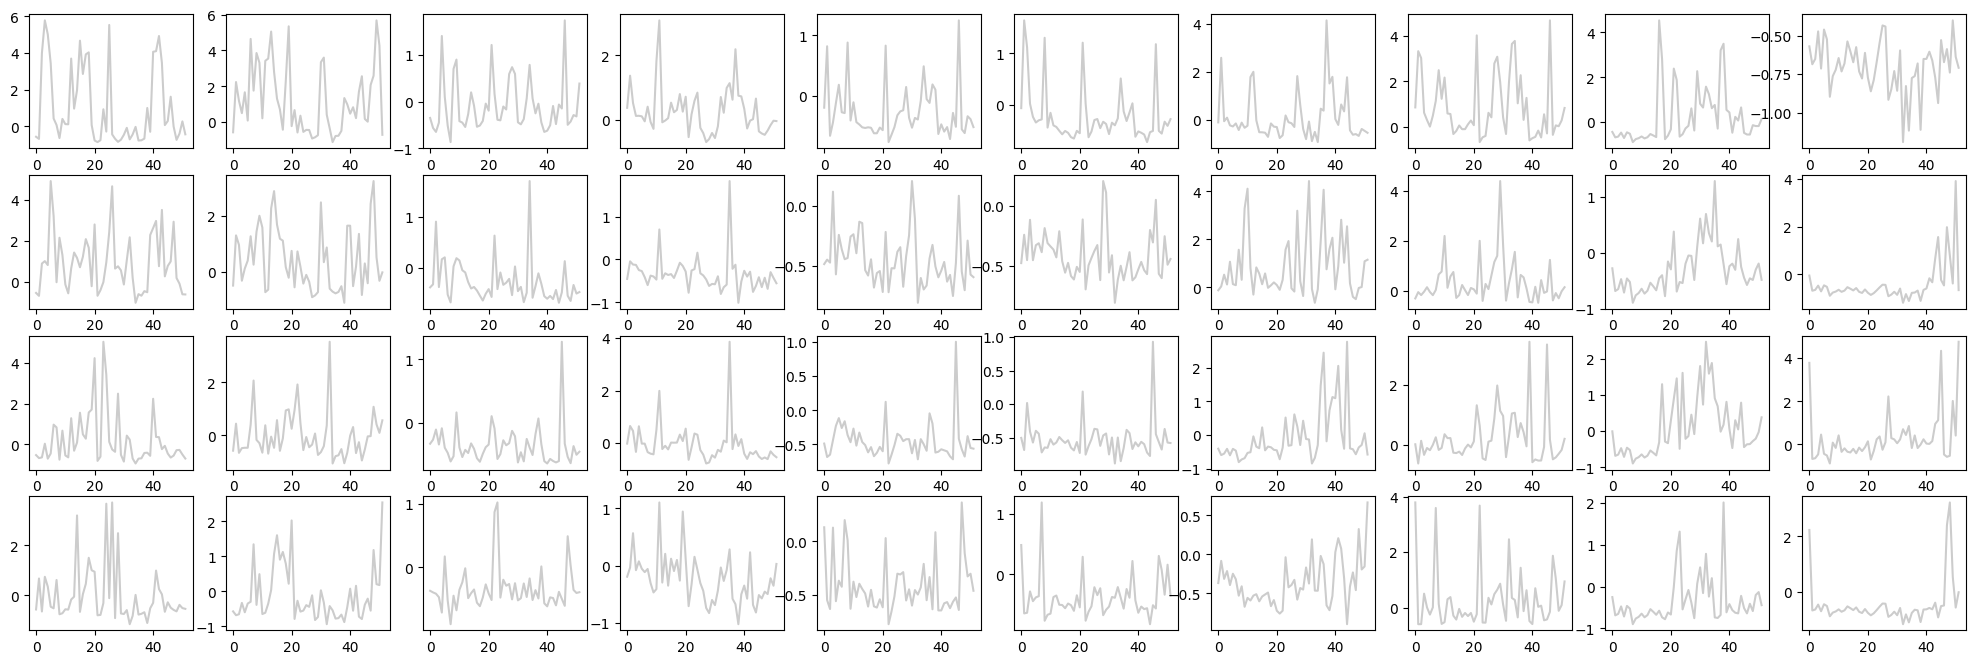

In [143]:
for yi in range(len(df_dc_agg_v2)):
    plt.subplot(4, 10, yi + 1)
    plt.plot(X_train[yi].ravel(), "k-", alpha=.2)

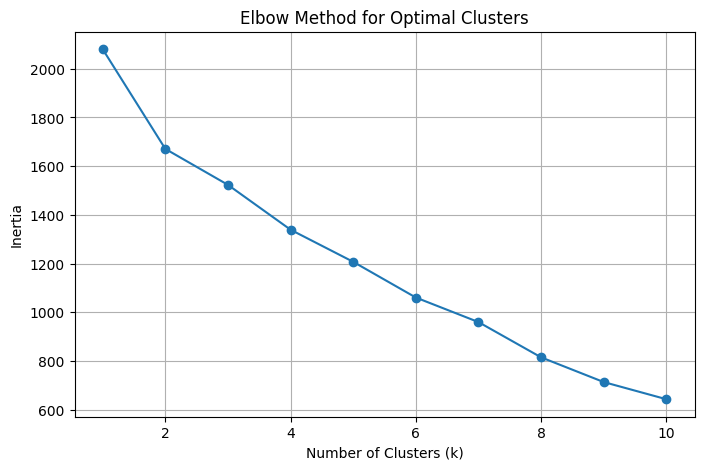

In [145]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_ss)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

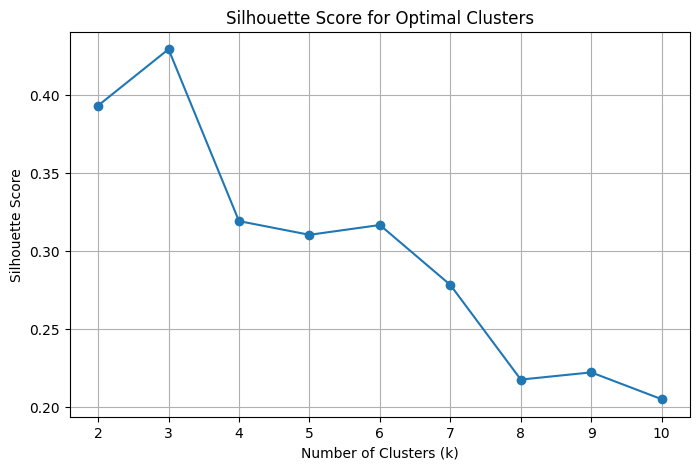

In [144]:
silhouette_scores = []

for k in range(2, 11):  # k starts from 2
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Step 2: Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [146]:
# Find the k value where silhouette score peaks
optimal_k_silhouette = range(2, 11)[np.argmax(silhouette_scores)]

# Elbow method suggests 3 or 4 as the likely k values (observed visually earlier)
optimal_k_elbow = 3  # Assuming k=4 based on earlier assessment

# Summarize and compare the results
comparison = {
    "Method": ["Elbow Method", "Silhouette Method"],
    "Optimal k": [optimal_k_elbow, optimal_k_silhouette],
}

comparison_df = pd.DataFrame(comparison)
display(comparison_df)

,Method,Optimal k
0,Elbow Method,3
1,Silhouette Method,3


In [157]:
sz = X_train.shape[1]

Euclidean k-means
Euclidean silhoutte: 0.38


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


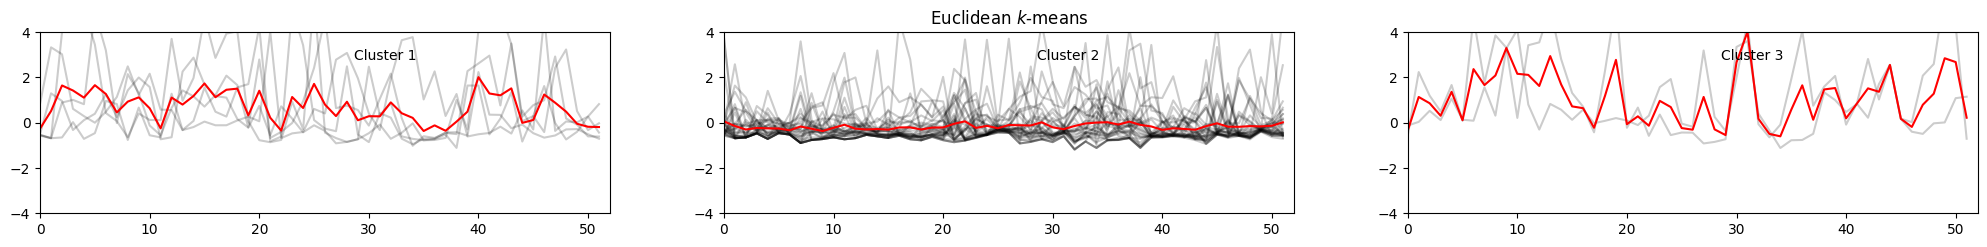

In [163]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=False, random_state=0)
y_pred_km = km.fit_predict(X_train)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


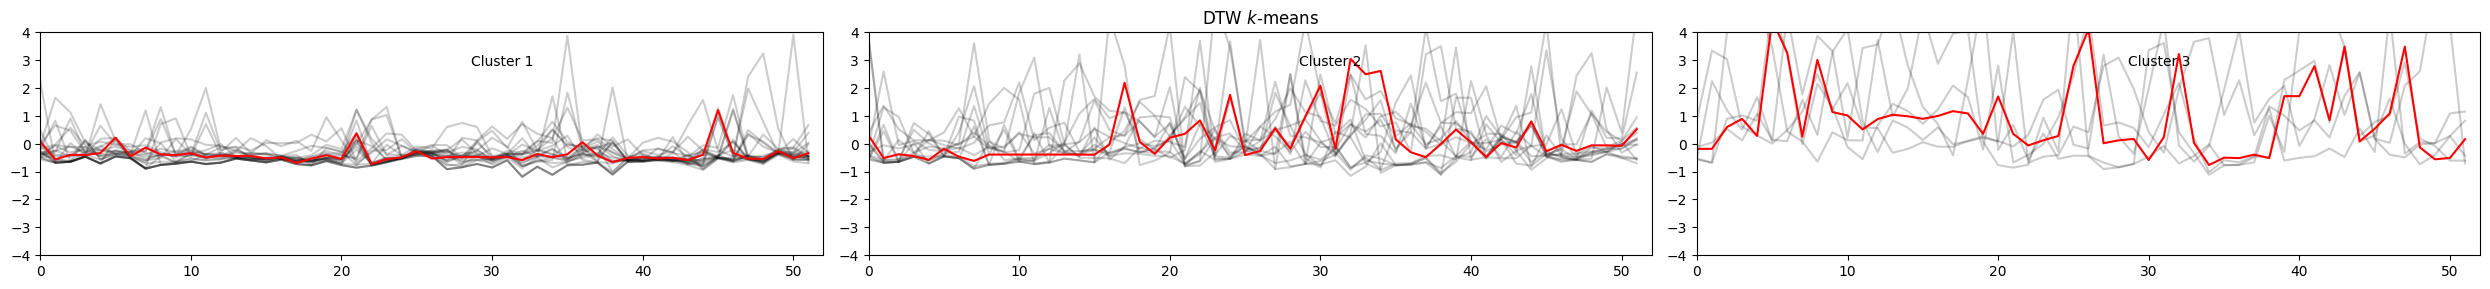

In [161]:
dtw_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
y_pred_dtw_km = dtw_km.fit_predict(X_train)
#print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(3):
    # The index for subplot should be within the range of 1 to (rows * cols)
    # In this case, rows=3, cols=3, so the index should be between 1 and 9
    plt.subplot(3, 3, yi + 1)  # Changed yi + 9 to yi + 1
    for xx in X_train[y_pred_dtw_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


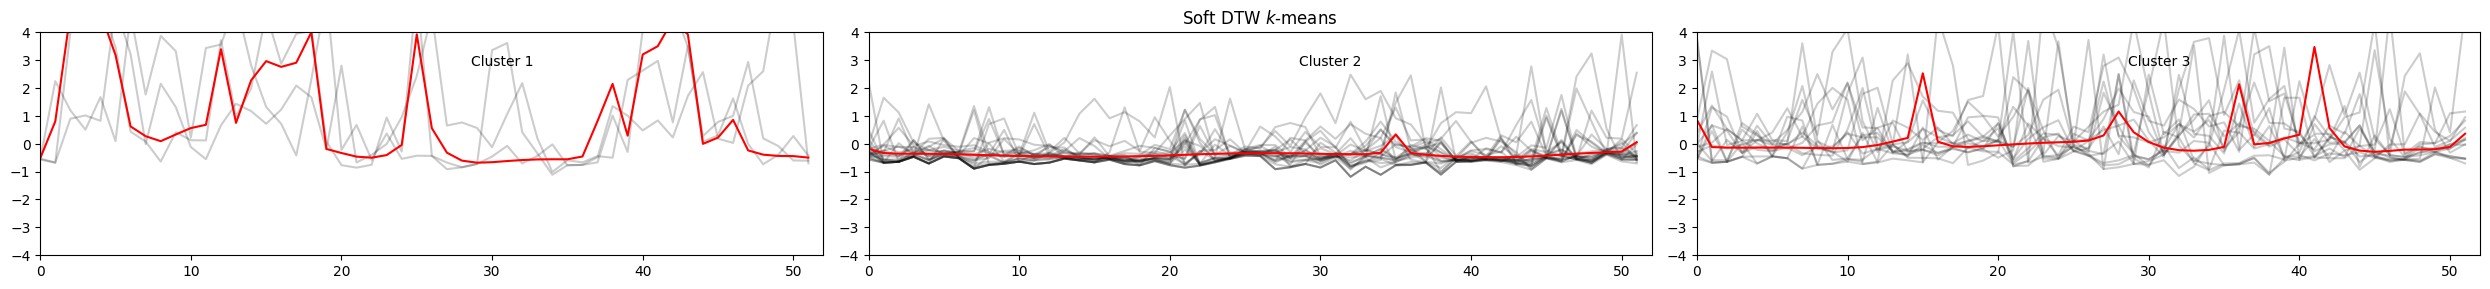

In [182]:
soft_dtw_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="softdtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
y_pred_soft_dtw_km = soft_dtw_km.fit_predict(X_train) # Changed dtw_km to soft_dtw_km

#print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(3):
    # The index for subplot should be within the range of 1 to (rows * cols)
    # In this case, rows=3, cols=3, so the index should be between 1 and 9
    plt.subplot(3, 3, yi + 1)  # Changed yi + 9 to yi + 1
    for xx in X_train[y_pred_soft_dtw_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(soft_dtw_km.cluster_centers_[yi].ravel(), "r-") # Now soft_dtw_km is fitted and has cluster_centers_
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft DTW $k$-means")

plt.tight_layout()
plt.show()

In [166]:
#print("Adjusted Rand Index for Euclidean: {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_km)))
#print("Adjusted Rand Index for DBA : {:.2f}".format(metrics.adjusted_rand_score(y_train, y_pred_dtw_km)))

In [175]:
# cluster 1 and 2 are swapped between euclidian and dtw method.
df_dc_agg_v2['eucidian_cluster'] = y_pred_km
df_dc_agg_v2['dtw_cluster'] = y_pred_dtw_km
df_dc_agg_v2['soft_dtw_cluster'] = y_pred_soft_dtw_km

In [181]:
for cluster_col in ['eucidian_cluster', 'dtw_cluster', 'soft_dtw_cluster']:
  print(f"Cluster {cluster_col}:")
  for i in range(3):
      count =  len(df_dc_agg_v2[df_dc_agg_v2[cluster_col] == i]) / len(df_dc_agg_v2) * 100
      print(f"The {count:.2f}% of the observations fall into Cluster {i + 1}")

Cluster eucidian_cluster:
The 12.50% of the observations fall into Cluster 1
The 82.50% of the observations fall into Cluster 2
The 5.00% of the observations fall into Cluster 3
Cluster dtw_cluster:
The 52.50% of the observations fall into Cluster 1
The 35.00% of the observations fall into Cluster 2
The 12.50% of the observations fall into Cluster 3
Cluster soft_dtw_cluster:
The 7.50% of the observations fall into Cluster 1
The 57.50% of the observations fall into Cluster 2
The 35.00% of the observations fall into Cluster 3


In [173]:
df_dc_agg_v2[df_dc_agg_v2['eucidian_cluster'] == 0]

PERIOD_WEEK,DC_PROD_ID,202401,202402,202403,202404,202405,202406,202407,202408,202409,...,202446,202447,202448,202449,202450,202451,202452,eucidian_cluster,dtw_cluster,soft_dtw_cluster
0,"155 FT. MILL BLACK & DECKER CORP, ~ CMCB204-2",0.0,0.0,676.0,2424.0,1362.0,1087.0,246.0,216.0,24.0,...,512.0,1999.0,294.0,0.0,0.0,333.0,45.0,0,2,0
7,"155 FT. MILL BLACK & DECKER CORP, ~ DCN680D1",350.0,640.0,534.0,420.0,238.0,128.0,260.0,453.0,653.0,...,142.0,4676.0,115.0,340.0,437.0,334.0,253.0,0,2,2
10,162 Northlake DC ~ CMCB204-2,8.0,1.0,224.0,573.0,363.0,1491.0,962.0,196.0,584.0,...,812.0,1455.0,1796.0,397.0,329.0,12.0,16.0,0,2,0
11,162 Northlake DC ~ CMCN618B,18.0,316.0,234.0,58.0,196.0,238.0,462.0,256.0,440.0,...,513.0,226.0,1541.0,1704.0,956.0,114.0,113.0,0,1,2
20,"164 Fontana DC Black & Decker,Inc. ~ CMCB204-2",8.0,0.0,0.0,192.0,0.0,0.0,384.0,384.0,0.0,...,42.0,11.0,12.0,190.0,124.0,47.0,0.0,0,1,2


In [168]:
df_dc_agg_v2[df_dc_agg_v2['dtw_cluster'] == 0]

PERIOD_WEEK,DC_PROD_ID,202401,202402,202403,202404,202405,202406,202407,202408,202409,...,202445,202446,202447,202448,202449,202450,202451,202452,eucidian_cluster,dtw_cluster
2,"155 FT. MILL BLACK & DECKER CORP, ~ DCN45RND1",54.0,19.0,0.0,8.0,503.0,157.0,2.0,6.0,294.0,...,140.0,237.0,2107.0,45.0,133.0,116.0,117.0,181.0,1,0
4,"155 FT. MILL BLACK & DECKER CORP, ~ DCN650D1",94.0,240.0,0.0,16.0,142.0,180.0,67.0,138.0,330.0,...,106.0,16.0,1673.0,22.0,57.0,74.0,95.0,33.0,1,0
5,"155 FT. MILL BLACK & DECKER CORP, ~ DCN660D1",126.0,371.0,257.0,193.0,115.0,34.0,59.0,138.0,415.0,...,66.0,17.0,1616.0,45.0,80.0,82.0,86.0,72.0,1,0
9,"155 FT. MILL BLACK & DECKER CORP, ~ DWFP1KIT",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
12,162 Northlake DC ~ DCN45RND1,48.0,59.0,226.0,40.0,210.0,186.0,2.0,51.0,160.0,...,42.0,35.0,704.0,25.0,43.0,75.0,52.0,40.0,1,0
13,162 Northlake DC ~ DCN623D1,28.0,102.0,77.0,133.0,110.0,52.0,28.0,66.0,77.0,...,51.0,70.0,21.0,81.0,22.0,107.0,75.0,25.0,1,0
14,162 Northlake DC ~ DCN650D1,21.0,38.0,26.0,229.0,34.0,61.0,42.0,101.0,66.0,...,30.0,33.0,661.0,21.0,16.0,117.0,24.0,19.0,1,0
15,162 Northlake DC ~ DCN660D1,23.0,71.0,29.0,138.0,62.0,37.0,55.0,114.0,116.0,...,118.0,140.0,631.0,11.0,59.0,155.0,54.0,44.0,1,0
18,162 Northlake DC ~ DCN920B,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,110.0,52.0,83.0,66.0,108.0,103.0,163.0,37.0,1,0
19,162 Northlake DC ~ DWFP1KIT,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,400.0,182.0,181.0,1309.0,654.0,18.0,1665.0,8.0,1,0


In [183]:
df_dc_agg_v2.groupby(['eucidian_cluster', 'dtw_cluster', 'soft_dtw_cluster']).count()

PERIOD_WEEK                                    DC_PROD_ID  202401  202402  \
eucidian_cluster dtw_cluster soft_dtw_cluster                               
0                1           2                          2       2       2   
                 2           0                          2       2       2   
                             2                          1       1       1   
1                0           1                         20      20      20   
                             2                          1       1       1   
                 1           1                          3       3       3   
                             2                          9       9       9   
2                2           0                          1       1       1   
                             2                          1       1       1   

PERIOD_WEEK                                    202403  202404  202405  202406  \
eucidian_cluster dtw_cluster soft_dtw_cluster                                   
0                1           2                      2       2       2       2   
                 2           0                      2       2       2       2   
                             2                      1       1       1       1   
1                0           1                     20      20      20      20   
                             2                      1       1       1       1   
                 1           1                      3       3       3       3   
                             2                      9       9       9       9   
2                2           0                      1       1       1       1   
                             2                      1       1       1       1   

PERIOD_WEEK                                    202407  202408  202409  ...  \
eucidian_cluster dtw_cluster soft_dtw_cluster                          ...   
0                1           2                      2       2       2  ...   
                 2           0                      2       2       2  ...   
                             2                      1       1       1  ...   
1                0           1                     20      20      20  ...   
                             2                      1       1       1  ...   
                 1           1                      3       3       3  ...   
                             2                      9       9       9  ...   
2                2           0                      1       1       1  ...   
                             2                      1       1       1  ...   

PERIOD_WEEK                                    202443  202444  202445  202446  \
eucidian_cluster dtw_cluster soft_dtw_cluster                                   
0                1           2                      2       2       2       2   
                 2           0                      2       2       2       2   
                             2                      1       1       1       1   
1                0           1                     20      20      20      20   
                             2                      1       1       1       1   
                 1           1                      3       3       3       3   
                             2                      9       9       9       9   
2                2           0                      1       1       1       1   
                             2                      1       1       1       1   

PERIOD_WEEK                                    202447  202448  202449  202450  \
eucidian_cluster dtw_cluster soft_dtw_cluster                                   
0                1           2                      2       2       2       2   
                 2           0                      2       2       2       2   
                             2                      1       1       1       1   
1                0           1                     20      20      20      20   
                       

In [184]:
df_dc_agg_v2.to_csv("dc_prod_week_agg_v1.csv")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


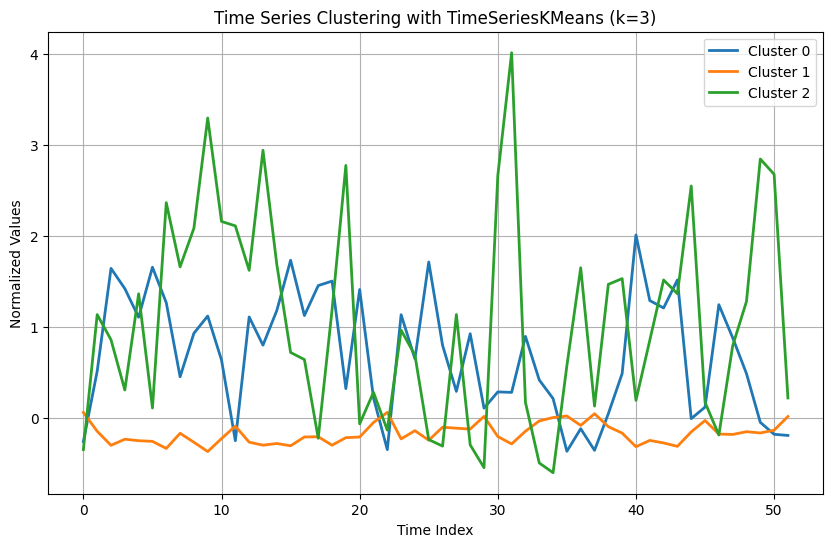

In [154]:
kmeans = TimeSeriesKMeans(n_clusters=3, metric="euclidean", random_state=0)
clusters_euclidean = kmeans.fit_predict(X_train)
df_dc_agg_v2['eucidian_cluster'] = clusters_euclidean
plt.figure(figsize=(10, 6))
for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    plt.plot(centroid.flatten(), label=f'Cluster {cluster_idx}', linewidth=2)
plt.title('Time Series Clustering with TimeSeriesKMeans (k=3)')
plt.xlabel('Time Index')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid()
plt.show()

In [118]:
df_ss.to_csv("ss.csv")

In [195]:
df_dc_ufr = pd.read_csv("dc_ufr.csv")
df_dc_ufr['PERIOD_WEEK'] = df_dc_ufr['PERIOD_WEEK'].astype(str)
df_dc_ufr.head()

,PERIOD_WEEK,PROD_ID,DELIVERED_DC_NAME,UFR
0,202415,CMCN618B,162 Northlake DC,1.000000
1,202445,DCN920B,"164 Fontana DC Black & Decker,Inc.",1.000000
2,202413,DCN680D1,162 Northlake DC,1.000000
3,202437,DCN660D1,162 Northlake DC,1.000000
4,202441,DCN623D1,166 Hagerstown DC,0.975904


In [196]:
df_dc_ufr_v1 = pd.merge(df_driver, df_dc_ufr, on = ['PERIOD_WEEK', 'DELIVERED_DC_NAME', 'PROD_ID'], how = 'left')
df_dc_ufr_v1['DC_PROD_ID'] = df_dc_ufr_v1['DELIVERED_DC_NAME'] + ' ~ ' + df_dc_ufr_v1['PROD_ID']
df_dc_ufr_v1.fillna(0, inplace=True)
df_dc_ufr_v1

,PERIOD_WEEK,DELIVERED_DC_NAME,PROD_ID,UFR,DC_PROD_ID
0,202401,162 Northlake DC,CMCB204-2,0.000000,162 Northlake DC ~ CMCB204-2
1,202401,162 Northlake DC,CMCN618B,0.000000,162 Northlake DC ~ CMCN618B
2,202401,162 Northlake DC,DCN45RND1,0.000000,162 Northlake DC ~ DCN45RND1
3,202401,162 Northlake DC,DCN623D1,0.000000,162 Northlake DC ~ DCN623D1
4,202401,162 Northlake DC,DCN650D1,0.000000,162 Northlake DC ~ DCN650D1
...,...,...,...,...,...
2075,202452,166 Hagerstown DC,DCN660D1,1.000000,166 Hagerstown DC ~ DCN660D1
2076,202452,166 Hagerstown DC,DCN680B,1.000000,166 Hagerstown DC ~ DCN680B
2077,202452,166 Hagerstown DC,DCN680D1,1.000000,166 Hagerstown DC ~ DCN680D1
2078,202452,166 Hagerstown DC,DCN920B,1.000000,166 Hagerstown DC ~ DCN920B


In [197]:
df_dc_ufr_v1.shape

(2080, 5)

In [201]:
df_dc_ufr_v2 = df_dc_ufr_v1.pivot_table(index=['DC_PROD_ID'], columns='PERIOD_WEEK', values='UFR').reset_index().fillna(0)
df_dc_ufr_v2.columns = [col if col == 'DC_PROD_ID' else 'ufr_val_' + str(col) for col in df_dc_ufr_v2.columns]
df_dc_ufr_v2

,DC_PROD_ID,ufr_val_202401,ufr_val_202402,ufr_val_202403,ufr_val_202404,ufr_val_202405,ufr_val_202406,ufr_val_202407,ufr_val_202408,ufr_val_202409,...,ufr_val_202443,ufr_val_202444,ufr_val_202445,ufr_val_202446,ufr_val_202447,ufr_val_202448,ufr_val_202449,ufr_val_202450,ufr_val_202451,ufr_val_202452
0,"155 FT. MILL BLACK & DECKER CORP, ~ CMCB204-2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.996868,0.975976,0.074534,1.000000,0.998499,0.993197,0.000000,0.000000,0.996997,0.977778
1,"155 FT. MILL BLACK & DECKER CORP, ~ CMCN618B",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,"155 FT. MILL BLACK & DECKER CORP, ~ DCN45RND1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,"155 FT. MILL BLACK & DECKER CORP, ~ DCN623D1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,"155 FT. MILL BLACK & DECKER CORP, ~ DCN650D1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,"155 FT. MILL BLACK & DECKER CORP, ~ DCN660D1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,"155 FT. MILL BLACK & DECKER CORP, ~ DCN680B",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,0.693548,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,"155 FT. MILL BLACK & DECKER CORP, ~ DCN680D1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,"155 FT. MILL BLACK & DECKER CORP, ~ DCN920B",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,"155 FT. MILL BLACK & DECKER CORP, ~ DWFP1KIT",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [202]:
df_dc_ufr_v2.shape, df_dc_agg_v2.shape

((40, 53), (40, 56))

In [210]:
df_dc_agg_v3 = pd.merge(df_dc_agg_v2, df_dc_ufr_v2, on = ['DC_PROD_ID'], how = 'left')
df_dc_agg_v3.columns = [col if col == 'DC_PROD_ID' or 'ufr_val_' in col else 'ord_qty_' + str(col) for col in df_dc_agg_v3.columns]
df_dc_agg_v3.head()

,DC_PROD_ID,ord_qty_202401,ord_qty_202402,ord_qty_202403,ord_qty_202404,ord_qty_202405,ord_qty_202406,ord_qty_202407,ord_qty_202408,ord_qty_202409,...,ufr_val_202443,ufr_val_202444,ufr_val_202445,ufr_val_202446,ufr_val_202447,ufr_val_202448,ufr_val_202449,ufr_val_202450,ufr_val_202451,ufr_val_202452
0,"155 FT. MILL BLACK & DECKER CORP, ~ CMCB204-2",0.0,0.0,676.0,2424.0,1362.0,1087.0,246.0,216.0,24.0,...,0.996868,0.975976,0.074534,1.0,0.998499,0.993197,0.0,0.0,0.996997,0.977778
1,"155 FT. MILL BLACK & DECKER CORP, ~ CMCN618B",0.0,466.0,268.0,376.0,564.0,152.0,1336.0,592.0,928.0,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.000000
2,"155 FT. MILL BLACK & DECKER CORP, ~ DCN45RND1",54.0,19.0,0.0,8.0,503.0,157.0,2.0,6.0,294.0,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000
3,"155 FT. MILL BLACK & DECKER CORP, ~ DCN623D1",232.0,327.0,170.0,228.0,198.0,157.0,122.0,290.0,139.0,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000
4,"155 FT. MILL BLACK & DECKER CORP, ~ DCN650D1",94.0,240.0,0.0,16.0,142.0,180.0,67.0,138.0,330.0,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000


In [211]:
df_dc_agg_v3.columns

Index(['DC_PROD_ID', 'ord_qty_202401', 'ord_qty_202402', 'ord_qty_202403',
       'ord_qty_202404', 'ord_qty_202405', 'ord_qty_202406', 'ord_qty_202407',
       'ord_qty_202408', 'ord_qty_202409',
       ...
       'ufr_val_202443', 'ufr_val_202444', 'ufr_val_202445', 'ufr_val_202446',
       'ufr_val_202447', 'ufr_val_202448', 'ufr_val_202449', 'ufr_val_202450',
       'ufr_val_202451', 'ufr_val_202452'],
      dtype='object', length=108)

In [218]:
order_cols = []
ufr_cols = []
for col in df_dc_agg_v3.columns:
  if 'ord_qty_' in col and 'cluster' not in col:
    order_cols.append(col)
  elif 'ufr_val_' in col:
    ufr_cols.append(col)

In [225]:
np.sum(df_dc_agg_v3.groupby([cluster_col])[order_cols].sum(), axis = 1)

,0
ord_qty_soft_dtw_cluster,
0,110571.0
1,157966.0
2,246969.0


In [229]:
np.sum(df_dc_agg_v3[(df_dc_agg_v3[cluster_col] == cluster_val)][order_cols].sum())

136013.0

In [231]:
for cluster_col in ['ord_qty_eucidian_cluster', 'ord_qty_dtw_cluster', 'ord_qty_soft_dtw_cluster']:
  for cluster_val in [0, 1, 2]:
      print(f"{cluster_col} cluster : {cluster_val}")
      print(f"Total Order Quantity: {np.sum(df_dc_agg_v3[(df_dc_agg_v3[cluster_col] == cluster_val)][order_cols].sum())}, Total UFR: {np.sum(df_dc_agg_v3[(df_dc_agg_v3[cluster_col] == cluster_val)][ufr_cols].sum())}")
  print("-----------------------------------------------------------------")

ord_qty_eucidian_cluster cluster : 0
Total Order Quantity: 136013.0, Total UFR: 192.58065299999998
ord_qty_eucidian_cluster cluster : 1
Total Order Quantity: 313469.0, Total UFR: 1228.7672759999996
ord_qty_eucidian_cluster cluster : 2
Total Order Quantity: 66024.0, Total UFR: 68.98511
-----------------------------------------------------------------
ord_qty_dtw_cluster cluster : 0
Total Order Quantity: 133872.0, Total UFR: 766.654806
ord_qty_dtw_cluster cluster : 1
Total Order Quantity: 216310.0, Total UFR: 538.210743
ord_qty_dtw_cluster cluster : 2
Total Order Quantity: 165324.0, Total UFR: 185.46749
-----------------------------------------------------------------
ord_qty_soft_dtw_cluster cluster : 0
Total Order Quantity: 110571.0, Total UFR: 103.95865599999999
ord_qty_soft_dtw_cluster cluster : 1
Total Order Quantity: 157966.0, Total UFR: 838.726717
ord_qty_soft_dtw_cluster cluster : 2
Total Order Quantity: 246969.0, Total UFR: 547.6476660000001
-------------------------------------

In [237]:
df_dc_agg_v3[df_dc_agg_v3['ord_qty_soft_dtw_cluster'] == 2]['DC_PROD_ID'].drop_duplicates().reset_index(drop=True)

,DC_PROD_ID
0,"155 FT. MILL BLACK & DECKER CORP, ~ DCN623D1"
1,"155 FT. MILL BLACK & DECKER CORP, ~ DCN680B"
2,"155 FT. MILL BLACK & DECKER CORP, ~ DCN680D1"
3,"155 FT. MILL BLACK & DECKER CORP, ~ DCN920B"
4,162 Northlake DC ~ CMCN618B
5,162 Northlake DC ~ DCN680B
6,162 Northlake DC ~ DCN680D1
7,"164 Fontana DC Black & Decker,Inc. ~ CMCB204-2"
8,"164 Fontana DC Black & Decker,Inc. ~ CMCN618B"
9,"164 Fontana DC Black & Decker,Inc. ~ DCN623D1"


In [236]:
df_dc_agg_v3[df_dc_agg_v3['ord_qty_soft_dtw_cluster'] == 1]['DC_PROD_ID'].drop_duplicates().reset_index(drop=True)

,DC_PROD_ID
0,"155 FT. MILL BLACK & DECKER CORP, ~ DCN45RND1"
1,"155 FT. MILL BLACK & DECKER CORP, ~ DCN650D1"
2,"155 FT. MILL BLACK & DECKER CORP, ~ DCN660D1"
3,"155 FT. MILL BLACK & DECKER CORP, ~ DWFP1KIT"
4,162 Northlake DC ~ DCN45RND1
5,162 Northlake DC ~ DCN623D1
6,162 Northlake DC ~ DCN650D1
7,162 Northlake DC ~ DCN660D1
8,162 Northlake DC ~ DCN920B
9,162 Northlake DC ~ DWFP1KIT


In [234]:
df_dc_agg_v3[df_dc_agg_v3['ord_qty_soft_dtw_cluster'] == 1]['DC_PROD_ID'].apply(lambda x : x.split(' ~ ')[1]).drop_duplicates().reset_index(drop=True)

,DC_PROD_ID
0,DCN45RND1
1,DCN650D1
2,DCN660D1
3,DWFP1KIT
4,DCN623D1
5,DCN920B
6,DCN680B
7,CMCN618B


In [235]:
df_dc_agg_v3[df_dc_agg_v3['ord_qty_soft_dtw_cluster'] == 2]['DC_PROD_ID'].apply(lambda x : x.split(' ~ ')[1]).drop_duplicates().reset_index(drop=True)

,DC_PROD_ID
0,DCN623D1
1,DCN680B
2,DCN680D1
3,DCN920B
4,CMCN618B
5,CMCB204-2
6,DWFP1KIT
